# Data Processing

In [1]:
from tensorflow import keras
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aneeshmahodaya","key":"6bd0ec4ea1fbe427f69683a92dd2a6ca"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats

!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

 98% 798M/812M [00:06<00:00, 172MB/s]
100% 812M/812M [00:06<00:00, 137MB/s]
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# ResNet50V2

In [5]:
conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(180, 180, 3),
    pooling="avg",
)

##  Fast feature extraction without data augmentation

### Extracting the ResNetV2 features and corresponding labels

In [6]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet_v2.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

### Defining and training the densely connected classifier

In [9]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(2048)) 
x = layers.Dense(256)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=40,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/40
63/63 [==============================] - 2s 6ms/step - loss: 0.3904 - accuracy: 0.9460 - val_loss: 0.1192 - val_accuracy: 0.9730
Epoch 2/40
63/63 [==============================] - 0s 4ms/step - loss: 0.2011 - accuracy: 0.9670 - val_loss: 0.1386 - val_accuracy: 0.9720
Epoch 3/40
63/63 [==============================] - 0s 4ms/step - loss: 0.1157 - accuracy: 0.9810 - val_loss: 0.1660 - val_accuracy: 0.9780
Epoch 4/40
63/63 [==============================] - 0s 4ms/step - loss: 0.1075 - accuracy: 0.9830 - val_loss: 0.5229 - val_accuracy: 0.9410
Epoch 5/40
63/63 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9860 - val_loss: 0.1325 - val_accuracy: 0.9730
Epoch 6/40
63/63 [==============================] - 0s 4ms/step - loss: 0.0598 - accuracy: 0.9880 - val_loss: 0.1812 - val_accuracy: 0.9730
Epoch 7/40
63/63 [==============================] - 0s 4ms/step - loss: 0.0773 - accuracy: 0.9865 - val_loss: 0.3858 - val_accuracy: 0.9620
Epoch 8/40
63/63 [==

### Plotting the results

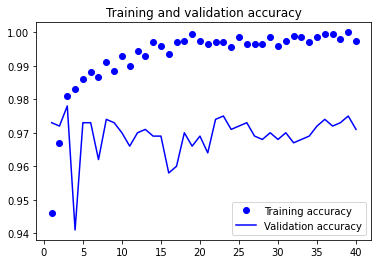

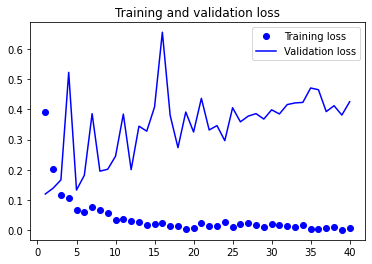

In [10]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluating the model on the test set

In [12]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.9700
Test accuracy: 0.970


## Feature extraction together with data augmentation

In [114]:
conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    pooling="avg",
)
conv_base.trainable = False

### Adding a data augmentation stage and a classifier to the convolutional base

In [115]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [116]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 9s 94ms/step - loss: 0.9826 - accuracy: 0.8855 - val_loss: 0.1581 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 5s 73ms/step - loss: 0.4950 - accuracy: 0.9330 - val_loss: 0.1787 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 5s 74ms/step - loss: 0.5791 - accuracy: 0.9310 - val_loss: 0.1677 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 5s 74ms/step - loss: 0.5944 - accuracy: 0.9400 - val_loss: 0.4411 - val_accuracy: 0.9430
Epoch 5/50
63/63 [==============================] - 5s 74ms/step - loss: 0.5552 - accuracy: 0.9455 - val_loss: 0.3482 - val_accuracy: 0.9580
Epoch 6/50
63/63 [==============================] - 5s 74ms/step - loss: 0.2910 - accuracy: 0.9570 - val_loss: 0.1802 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 5s 74ms/step - loss: 0.4017 - accuracy: 0.9540 - val_loss: 0.1679 - val_accuracy: 0.9750
Epoch 8/50
63

### Plotting the results

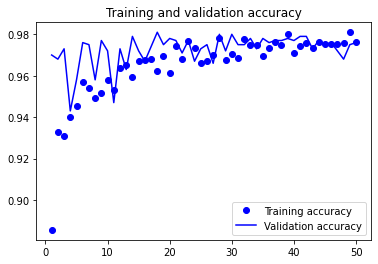

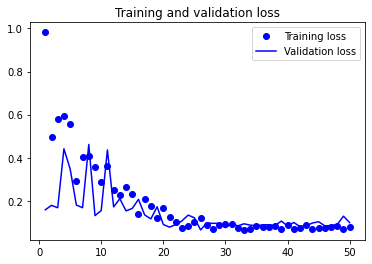

In [117]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluating the model on the test set

In [118]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 46ms/step - loss: 0.0757 - accuracy: 0.9765
Test accuracy: 0.976


## Fine-tuning a pretrained model

### Freezing all layers except last 3 convolutions

In [119]:
conv_base.trainable=True
for layer in conv_base.layers:
  layer.trainable=False

for layer in conv_base.layers[-14:]:
  if isinstance(layer,keras.layers.Conv2D):
    layer.trainable=True
    print(layer.name)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

conv5_block3_1_conv
conv5_block3_2_conv
conv5_block3_3_conv


### Fine Tuning

In [120]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 100ms/step - loss: 0.0612 - accuracy: 0.9820 - val_loss: 0.0789 - val_accuracy: 0.9740
Epoch 2/30
63/63 [==============================] - 5s 81ms/step - loss: 0.0647 - accuracy: 0.9795 - val_loss: 0.0794 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - 5s 80ms/step - loss: 0.0537 - accuracy: 0.9835 - val_loss: 0.0795 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 5s 81ms/step - loss: 0.0426 - accuracy: 0.9855 - val_loss: 0.0822 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 6s 88ms/step - loss: 0.0376 - accuracy: 0.9845 - val_loss: 0.0768 - val_accuracy: 0.9770
Epoch 6/30
63/63 [==============================] - 6s 88ms/step - loss: 0.0378 - accuracy: 0.9855 - val_loss: 0.0763 - val_accuracy: 0.9810
Epoch 7/30
63/63 [==============================] - 5s 82ms/step - loss: 0.0367 - accuracy: 0.9860 - val_loss: 0.0784 - val_accuracy: 0.9780
Epoch 8/30


### Plotting the results

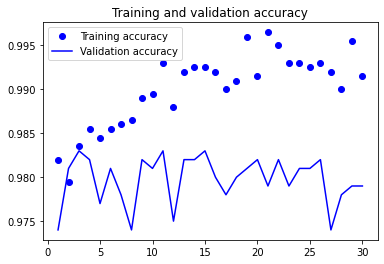

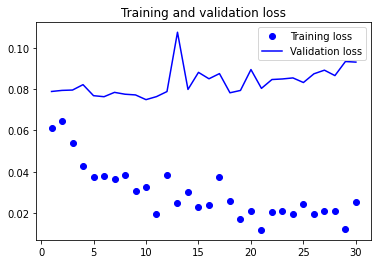

In [121]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluating the model on the test set

In [122]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 4s 46ms/step - loss: 0.0823 - accuracy: 0.9770
Test accuracy: 0.977
